# Bernoulli Armed Bandit with Random Normal Walk

In [1]:
import jax
import pandas as pd
import numpy as np
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
from functools import partial
from bayes_opt import BayesianOptimization

In [3]:
from rebayes_mini.callbacks import get_null
from rebayes_mini.methods.gauss_filter import BernoulliFilter
from rebayes_mini.callbacks import get_predicted_mean, get_predicted_bel
from rebayes_mini.methods.adaptive import ExpfamRLSR,  ExpfamEBA, ExpfamRLPR

In [4]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 15
plt.rcParams["axes.spines.right"]= False
plt.rcParams["axes.spines.top"] = False
plt.rc("text", usetex=True)

sns.set_palette("colorblind")

## Data-generating process

In [5]:
def process_step(probas, change):
    probas = probas + change
    probas = jnp.clip(probas, 0.0, 1.0)
    return probas, probas

def sample_process(key, std, n_steps, n_arms):
    key_init, key_steps, key_reward = jax.random.split(key, 3)
    proba_init = jax.random.uniform(key_init, (n_arms,))
    steps = jax.random.normal(key_steps, (n_steps, n_arms)) * std
    
    _, probas = jax.lax.scan(process_step, proba_init, steps)
    rewards = jax.random.bernoulli(key_reward, p=probas)
    return probas, rewards

In [6]:
key = jax.random.PRNGKey(314)
key_sim, key_eval = jax.random.split(key)

In [7]:
n_steps = 10_000
n_arms = 10

std = jnp.sqrt(0.03)
# std = jnp.sqrt(1e-4)
probas, rewards = sample_process(key_sim, std, n_steps, n_arms)

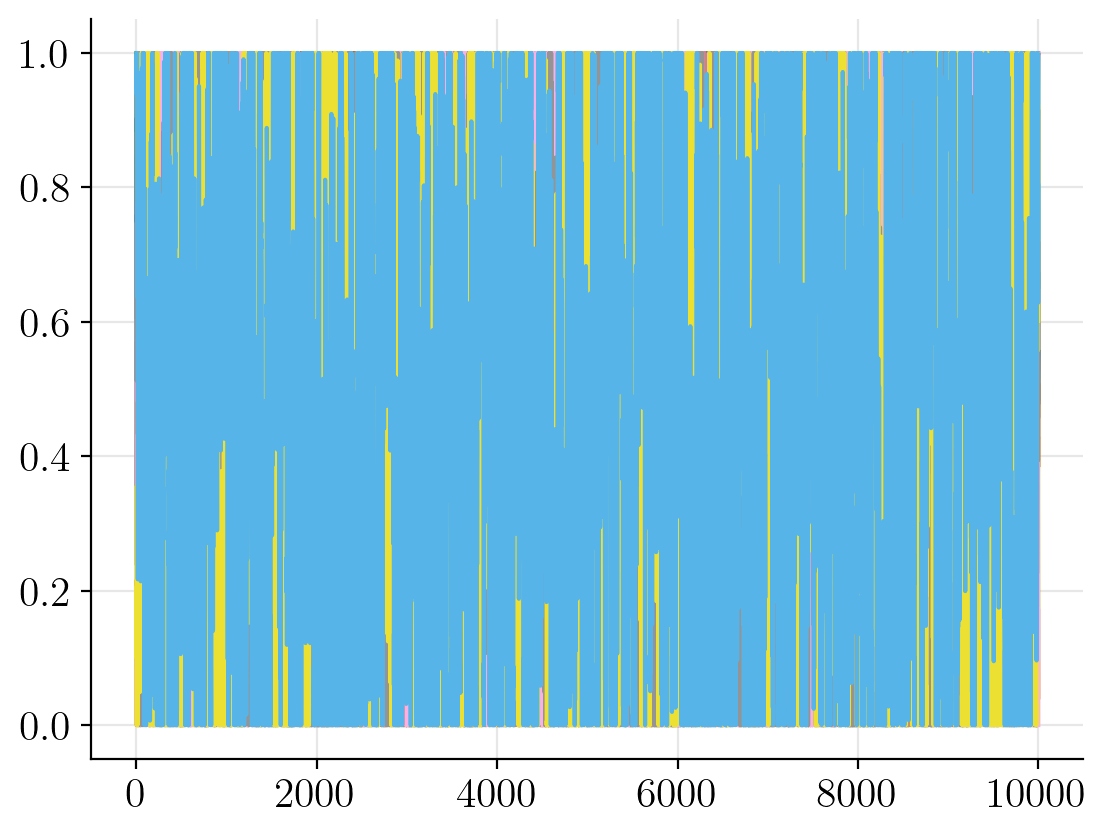

In [8]:
plt.plot(probas)
plt.grid(alpha=0.3)

# Bandits

## C-LSSM

In [9]:
def choose_arm_and_update(bel, key, Yt, filter):
    # Thompson-sampling step: sample from posterior distribution over model parameters
    mean_pred = jax.random.multivariate_normal(key, bel.mean, bel.cov)

    # Sample expectation over all possible arms
    eta = jax.vmap(filter.apply_fn, in_axes=(0, None))(bel.mean, None)
    arms_est = filter.mean(eta)

    # Take arm with highest sampled reward
    arm = arms_est.argmax()
    reward_est = arms_est[arm]

    # return updated posterior belief for given arm
    reward = Yt[arm] * 1.0
    bel_arm = jax.tree.map(lambda x: x[arm], bel)
    bel_arm = filter._predict(bel_arm)
    bel_arm = filter._update(bel_arm, reward, None)

    # Update all beliefs
    bel = jax.tree.map(lambda x,y: x.at[arm].set(y), bel, bel_arm)

    out = {
        "arm": arm,
        "reward": reward,
        "mean": bel.mean,
        "reward_est": reward_est,
    }
    return bel, out


def step(bel, xs, filter):
    key, y = xs
    bel, res = choose_arm_and_update(bel, key, y, filter)
    return bel, res


def apply_fn(w, _):
    return jnp.atleast_1d(w)


def run_caci(q, key, n_arms, n_steps, std):
    key_simulate, key_init, key_run = jax.random.split(key, 3)
    keys = jax.random.split(key_run, n_steps)
    _, y = sample_process(key_simulate, std, n_steps, n_arms)
    
    filter = BernoulliFilter(apply_fn, dynamics_covariance=q)

    mean_init = jax.random.uniform(key_init, shape=(n_arms,))
    bel_init = jax.vmap(filter.init_bel, in_axes=(0, None))(mean_init, 1.0)
    
    pstep = partial(step, filter=filter)
    items = (keys, y)
    bel_final, hist = jax.lax.scan(pstep, bel_init, items)
    return y, hist

In [10]:
@partial(jax.jit, static_argnames=("n_steps", "n_arms",))
def eval_caci_hist(q, key, std, n_arms, n_steps):
    oracle, hist =  run_caci(q, key, n_arms, n_steps, std)
    regret = oracle.max(axis=1).cumsum() - hist["reward"].cumsum()
    return regret
    
@partial(jax.jit, static_argnames=("n_steps", "n_arms",))
def eval_caci(q, key, std, n_arms, n_steps):
    oracle, hist =  run_caci(q, key, n_arms, n_steps, std)
    regret = oracle.max(axis=1).sum() - hist["reward"].sum()
    return -regret

### Warmup

In [11]:
std = jnp.sqrt(0.003)
n_sims = 100
key_sims, key_warmup = jax.random.split(key_eval, 2)
keys_sims = jax.random.split(key_sims, n_sims)

In [12]:
n_arms = 10
n_steps = 10_000

In [13]:
bo = BayesianOptimization(
    partial(eval_caci,
            key=key_warmup, n_arms=n_arms, n_steps=n_steps, std=std),
    pbounds = {"q": (0.0, 10.0)},
    random_state=314,
    # verbose=1
)
bo.maximize()

|   iter    |  target   |     q     |
-------------------------------------
| 1         | -3.214e+0 | 9.169     |
| 2         | -3.114e+0 | 5.885     |
| 3         | -3.061e+0 | 2.65      |
| 4         | -3.07e+03 | 7.832     |
| 5         | -3.214e+0 | 9.18      |
| 6         | -3.293e+0 | 3.694     |
| 7         | -2.928e+0 | 2.079     |
| 8         | -3.026e+0 | 1.244     |
| 9         | -3.001e+0 | 0.001952  |
| 10        | -3.245e+0 | 6.934     |
| 11        | -2.955e+0 | 1.747     |
| 12        | -3.126e+0 | 0.5259    |
| 13        | -3.205e+0 | 5.028     |
| 14        | -2.982e+0 | 2.256     |
| 15        | -3.229e+0 | 9.997     |
| 16        | -2.997e+0 | 1.938     |
| 17        | -3.161e+0 | 1.524     |
| 18        | -3.107e+0 | 1.002     |
| 19        | -3.051e+0 | 0.2009    |
| 20        | -2.928e+0 | 2.08      |
| 21        | -3.07e+03 | 8.263     |
| 22        | -3.247e+0 | 3.017     |
| 23        | -3.07e+03 | 8.608     |
| 24        | -3.087e+0 | 4.393     |
| 25        

### Test

In [14]:
q = bo.max["params"]["q"].item()
res_caci = jax.vmap(eval_caci_hist, in_axes=(None, 0, None, None, None))(q, keys_sims, std, n_arms, n_steps)

## RL-OUPR

In [15]:
@partial(jax.vmap, in_axes=(0, 0, None))
def predict_mean_agents(key, bel, agent):
    mean_pred = jax.random.multivariate_normal(
        key, bel.mean, bel.cov
    )

    eta = jax.vmap(agent.filter.apply_fn, in_axes=(0, None))(mean_pred, None)
    arms_est = agent.filter.mean(eta)
    posterior = jnp.exp(bel.log_joint - jax.nn.logsumexp(bel.log_joint))
    # Weight estimates by probability
    arms_est = jnp.einsum("km,k->m", arms_est, posterior)

    return arms_est

def choose_arm_and_update(bel, key, Yt, agent, bel_prior, predict_fn):
    # Thompson-sampling step: sample from posterior distribution over model parameters
    keys_arms = jax.random.split(key, len(Yt))
    arms_est = predict_fn(keys_arms, bel, agent)

    # Take arm with highest sampled reward
    arm = arms_est.squeeze().argmax()
    reward_est = arms_est[arm]

    # return updated posterior belief for given arm
    reward = jnp.atleast_1d(Yt[arm]) * 1.0
    bel_arm = jax.tree.map(lambda x: x[arm], bel)
    bel_arm, _ = agent.step(reward, None, bel_arm, bel_prior, get_null)

    # Update all beliefs
    bel = jax.tree.map(lambda x,y: x.at[arm].set(y), bel, bel_arm)

    out = {
        "arm": arm,
        "reward": reward,
        # "mean": bel.mean,
        "reward_est": reward_est
    }
    return bel, out


def step(bel, xs, agent, bel_prior, predict_rewards_fn):
    key, y = xs
    bel, res = choose_arm_and_update(bel, key, y, agent, bel_prior, predict_rewards_fn)
    return bel, res

In [16]:
def run_rlspr(p, key, n_arms, n_steps, std):
    key_simulate, key_init, key_run = jax.random.split(key, 3)
    keys = jax.random.split(key_run, n_steps)
    _, y = sample_process(key_simulate, std, n_steps, n_arms)
    
    base_filter = BernoulliFilter(apply_fn, dynamics_covariance=0.0)
    filter = ExpfamRLSR(
        p_change=p,
        K=1,
        shock=1.0,
        deflate_mean=True,
        filter=base_filter
    )

    mean_init = jax.random.uniform(key_init, shape=(n_arms,))
    bel_init = jax.vmap(filter.init_bel, in_axes=(0, None, None))(mean_init, 1.0, 0.0)
    bel_prior = jax.tree.map(lambda x: x[0,0], bel_init)
    
    pstep = partial(
        step,
        agent=filter, bel_prior=bel_prior, predict_rewards_fn=predict_mean_agents
    )
    items = (keys, y)
    bel_final, hist = jax.lax.scan(pstep, bel_init, items)
    return y, hist

In [17]:
@partial(jax.jit, static_argnames=("n_steps", "n_arms",))
def eval_rlspr_hist(p, key, std, n_arms, n_steps):
    oracle, hist =  run_rlspr(p, key, n_arms, n_steps, std)
    regret = oracle.max(axis=1).cumsum() - hist["reward"].cumsum()
    return regret
    
@partial(jax.jit, static_argnames=("n_steps", "n_arms",))
def eval_rlspr(p, key, std, n_arms, n_steps):
    oracle, hist =  run_rlspr(p, key, n_arms, n_steps, std)
    regret = oracle.max(axis=1).sum() - hist["reward"].sum()
    return -regret

## Warmup

In [18]:
bo = BayesianOptimization(
    partial(eval_rlspr,
            key=key_warmup, n_arms=n_arms, n_steps=n_steps, std=std),
    pbounds = {"p": (0.0, 1.0)},
    random_state=314,
    # verbose=1
)
bo.maximize()

|   iter    |  target   |     p     |
-------------------------------------
| 1         | -5.03e+03 | 0.9169    |
| 2         | -5.03e+03 | 0.5885    |
| 3         | -2.299e+0 | 0.265     |
| 4         | -5.03e+03 | 0.7832    |
| 5         | -5.03e+03 | 0.918     |
| 6         | -2.407e+0 | 0.03837   |
| 7         | -2.52e+03 | 0.1574    |
| 8         | -2.466e+0 | 0.3453    |
| 9         | -3.305e+0 | 0.0001952 |
| 10        | -2.539e+0 | 0.09304   |
| 11        | -2.451e+0 | 0.4349    |
| 12        | -2.395e+0 | 0.2152    |
| 13        | -2.447e+0 | 0.3945    |
| 14        | -2.395e+0 | 0.215     |
| 15        | -2.364e+0 | 0.3002    |
| 16        | -2.42e+03 | 0.06065   |
| 17        | -2.506e+0 | 0.4792    |
| 18        | -2.379e+0 | 0.2433    |
| 19        | -2.331e+0 | 0.2804    |
| 20        | -2.496e+0 | 0.1881    |
| 21        | -2.541e+0 | 0.4583    |
| 22        | -2.443e+0 | 0.1264    |
| 23        | -2.393e+0 | 0.321     |
| 24        | -2.38e+03 | 0.2696    |
| 25        

In [19]:
p = bo.max["params"]["p"].item()
res_rlspr = jax.vmap(eval_rlspr_hist, in_axes=(None, 0, None, None, None))(p, keys_sims, std, n_arms, n_steps)
res_rlspr[:, -1].mean()

Array(2339.13, dtype=float32)

## RL-PR

In [20]:
def run_rlpr(p, key, n_arms, n_steps, std):
    key_simulate, key_init, key_run = jax.random.split(key, 3)
    keys = jax.random.split(key_run, n_steps)
    _, y = sample_process(key_simulate, std, n_steps, n_arms)
    
    base_filter = BernoulliFilter(apply_fn, dynamics_covariance=0.0)
    filter = ExpfamRLPR(
        p_change=p,
        K=1,
        filter=base_filter
    )

    mean_init = jax.random.uniform(key_init, shape=(n_arms,))
    bel_init = jax.vmap(filter.init_bel, in_axes=(0, None, None))(mean_init, 1.0, 0.0)
    bel_prior = jax.tree.map(lambda x: x[0,0], bel_init)
    
    pstep = partial(step, agent=filter, bel_prior=bel_prior, predict_rewards_fn=predict_mean_agents)
    items = (keys, y)
    bel_final, hist = jax.lax.scan(pstep, bel_init, items)
    return y, hist

In [21]:
@partial(jax.jit, static_argnames=("n_steps", "n_arms",))
def eval_rlpr_hist(p, key, std, n_arms, n_steps):
    oracle, hist =  run_rlpr(p, key, n_arms, n_steps, std)
    regret = oracle.max(axis=1).cumsum() - hist["reward"].cumsum()
    return regret


@partial(jax.jit, static_argnames=("n_steps", "n_arms",))
def eval_rlpr(p, key, std, n_arms, n_steps):
    oracle, hist =  run_rlpr(p, key, n_arms, n_steps, std)
    regret = oracle.max(axis=1).sum() - hist["reward"].sum()
    return -regret

## Warmup

In [22]:
bo = BayesianOptimization(
    partial(eval_rlpr,
            key=key_warmup, n_arms=n_arms, n_steps=n_steps, std=std),
    pbounds = {"p": (0.0, 1.0)},
    random_state=314,
    # verbose=1
)
bo.maximize()

|   iter    |  target   |     p     |
-------------------------------------
| 1         | -5.03e+03 | 0.9169    |
| 2         | -5.03e+03 | 0.5885    |
| 3         | -4.772e+0 | 0.265     |
| 4         | -5.03e+03 | 0.7832    |
| 5         | -5.03e+03 | 0.918     |
| 6         | -4.772e+0 | 0.03837   |
| 7         | -4.772e+0 | 0.1533    |
| 8         | -4.772e+0 | 5.404e-05 |
| 9         | -4.772e+0 | 0.2167    |
| 10        | -4.772e+0 | 0.09748   |
| 11        | -4.772e+0 | 0.2441    |
| 12        | -4.772e+0 | 0.3082    |
| 13        | -4.772e+0 | 0.06818   |
| 14        | -4.772e+0 | 0.2439    |
| 15        | -4.772e+0 | 0.183     |
| 16        | -4.392e+0 | 0.2911    |
| 17        | -4.772e+0 | 0.2838    |
| 18        | -4.392e+0 | 0.2954    |
| 19        | -4.392e+0 | 0.2932    |
| 20        | -4.513e+0 | 0.4436    |
| 21        | -4.488e+0 | 0.4528    |
| 22        | -4.452e+0 | 0.4636    |
| 23        | -4.561e+0 | 0.474     |
| 24        | -4.513e+0 | 0.4306    |
| 25        

In [23]:
p = bo.max["params"]["p"].item()
res_rlpr = jax.vmap(
    eval_rlpr_hist, in_axes=(None, 0, None, None, None))(p, keys_sims, std, n_arms, n_steps
)
res_rlpr[:, -1].mean()

Array(4630.02, dtype=float32)

## CPP-OU

In [24]:
@partial(jax.vmap, in_axes=(0, 0, None))
def predict_mean_caci(key, bel, agent):
    mean_pred = jax.random.multivariate_normal(
        key, bel.mean, bel.cov
    )

    eta = agent.filter.apply_fn(mean_pred, None)
    arms_est = agent.filter.mean(eta)

    return arms_est


def choose_arm_and_update(bel, key, Yt, agent, predict_fn):
    # Thompson-sampling step: sample from posterior distribution over model parameters
    keys_arms = jax.random.split(key, len(Yt))
    arms_est = predict_fn(keys_arms, bel, agent)

    # Take arm with highest sampled reward
    arm = arms_est.squeeze().argmax()
    reward_est = arms_est[arm]

    # return updated posterior belief for given arm
    reward = jnp.atleast_1d(Yt[arm]) * 1.0
    bel_arm = jax.tree.map(lambda x: x[arm], bel)
    bel_arm = agent.step(reward, None, bel_arm)

    # Update all beliefs
    bel = jax.tree.map(lambda x,y: x.at[arm].set(y), bel, bel_arm)

    out = {
        "arm": arm,
        "reward": reward,
        # "mean": bel.mean,
        "reward_est": reward_est
    }
    return bel, out


def step(bel, xs, agent, predict_rewards_fn):
    key, y = xs
    bel, res = choose_arm_and_update(bel, key, y, agent, predict_rewards_fn)
    return bel, res

In [25]:
def run_cppd(lr, drift, key, n_arms, n_steps, std):
    key_simulate, key_init, key_run = jax.random.split(key, 3)
    keys = jax.random.split(key_run, n_steps)
    _, y = sample_process(key_simulate, std, n_steps, n_arms)
    
    base_filter = BernoulliFilter(apply_fn, dynamics_covariance=0.0)
    filter = ExpfamEBA(
        n_inner=2, ebayes_lr=lr, state_drift=drift,
        deflate_mean=True, deflate_covariance=True, filter=base_filter
    )
    
    mean_init = jax.random.uniform(key_init, shape=(n_arms,))
    bel_init = jax.vmap(filter.init_bel, in_axes=(0, None, None))(mean_init, 1.0, 0.0)
    
    pstep = partial(
        step,
        agent=filter, predict_rewards_fn=predict_mean_caci
    )
    items = (keys, y)
    bel_final, hist = jax.lax.scan(pstep, bel_init, items)
    return y, hist

In [26]:
@partial(jax.jit, static_argnames=("n_steps", "n_arms",))
def eval_cppd_hist(lr, drift, key, std, n_arms, n_steps):
    oracle, hist =  run_cppd(lr, drift, key, n_arms, n_steps, std)
    regret = oracle.max(axis=1).cumsum() - hist["reward"].cumsum()
    return regret


@partial(jax.jit, static_argnames=("n_steps", "n_arms",))
def eval_cppd(lr, drift, key, std, n_arms, n_steps):
    oracle, hist =  run_cppd(lr, drift, key, n_arms, n_steps, std)
    regret = oracle.max(axis=1).sum() - hist["reward"].sum()
    return -regret

## Warmup

In [27]:
bo = BayesianOptimization(
    partial(eval_cppd,
            key=key_warmup, n_arms=n_arms, n_steps=n_steps, std=std),
    pbounds = {"drift": (0.0, 2.0), "lr": (0.0, 1.0)},
    random_state=314,
    # verbose=1
)
bo.maximize()

|   iter    |  target   |   drift   |    lr     |
-------------------------------------------------
| 1         | -3.122e+0 | 1.834     | 0.5885    |
| 2         | -2.836e+0 | 0.5301    | 0.7832    |
| 3         | -3.265e+0 | 1.836     | 0.8274    |
| 4         | -3.4e+03  | 1.456     | 0.2605    |
| 5         | -3.779e+0 | 1.824     | 0.2608    |
| 6         | -2.751e+0 | 0.8764    | 0.2295    |
| 7         | -2.776e+0 | 0.7503    | 0.4238    |
| 8         | -2.926e+0 | 0.02428   | 0.8845    |
| 9         | -2.758e+0 | 0.5383    | 0.1307    |
| 10        | -3.234e+0 | 1.469     | 0.3786    |
| 11        | -2.395e+0 | 0.2104    | 0.4245    |
| 12        | -3.016e+0 | 1.406     | 0.2218    |
| 13        | -2.775e+0 | 1.664     | 0.05672   |
| 14        | -2.963e+0 | 1.427     | 0.01679   |
| 15        | -2.696e+0 | 0.255     | 0.291     |
| 16        | -3.261e+0 | 0.7451    | 0.885     |
| 17        | -3.242e+0 | 1.432     | 0.7848    |
| 18        | -2.549e+0 | 0.2152    | 0.4332    |


In [28]:
drift = bo.max["params"]["drift"].item()
lr = bo.max["params"]["lr"].item()

res_cppd = jax.vmap(eval_cppd_hist, in_axes=(None, None, 0, None, None, None))(
    drift, lr, keys_sims, std, n_arms, n_steps
)
res_cppd[:, -1].mean()

Array(2594.16, dtype=float32)

## results

In [30]:
results = {
    "RL-OUPR*": res_rlspr,
    "RL-PR": res_rlpr,
    "CPP-OU": res_cppd,
    "C-ACI": res_caci,
}
results = jax.tree.map(np.array, results)

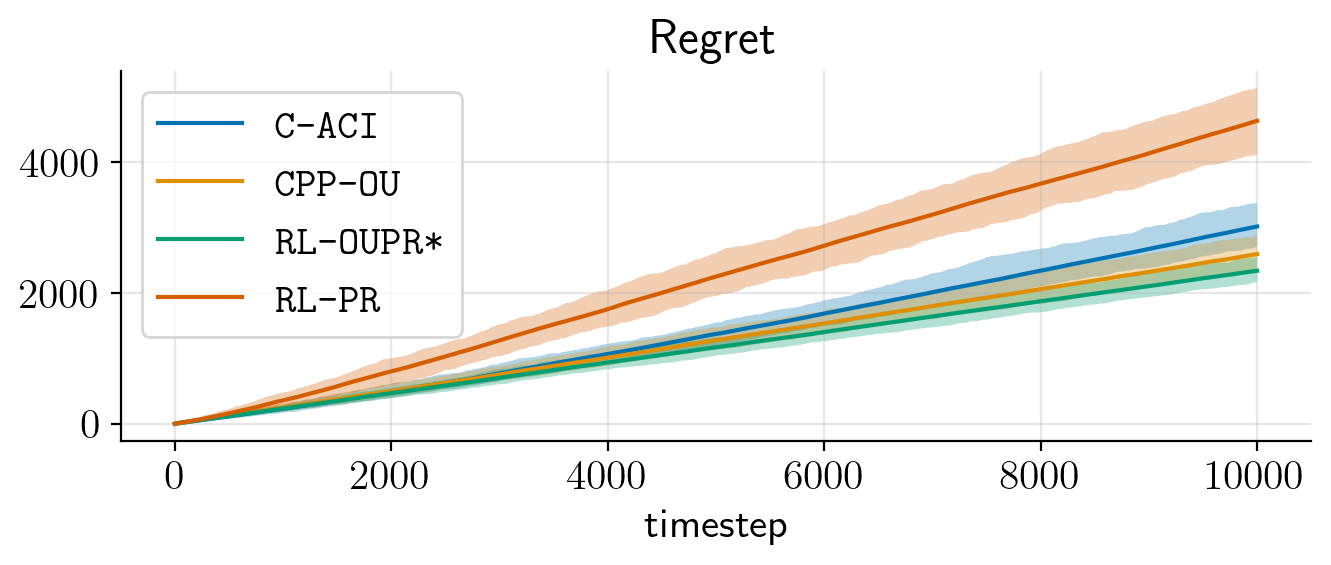

In [31]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.5))

for method in results:
    mid = results[method].mean(axis=0)
    low = np.quantile(results[method], 0.05, axis=0)
    up = np.quantile(results[method], 0.95, axis=0)
    
    plt.plot(mid, label=method)
    plt.fill_between(np.arange(len(mid)), low, up, alpha=0.3)
plt.legend()

l = plt.legend()
for text in l.get_texts():
    lab = text.get_text()
    # color = "teal" if "SPR" in lab else "crimson"
    # text.set_color(color)
    text.set_text(r"\texttt{" + lab + "}")

plt.xlabel("timestep")
plt.title("Regret")
plt.grid(alpha=0.3)
plt.savefig("../figures/regret-bandit.png", dpi=300, bbox_inches="tight")

In [32]:
results_last = jax.tree.map(lambda x: x[:, -1], results)
results_last = pd.DataFrame(results_last)

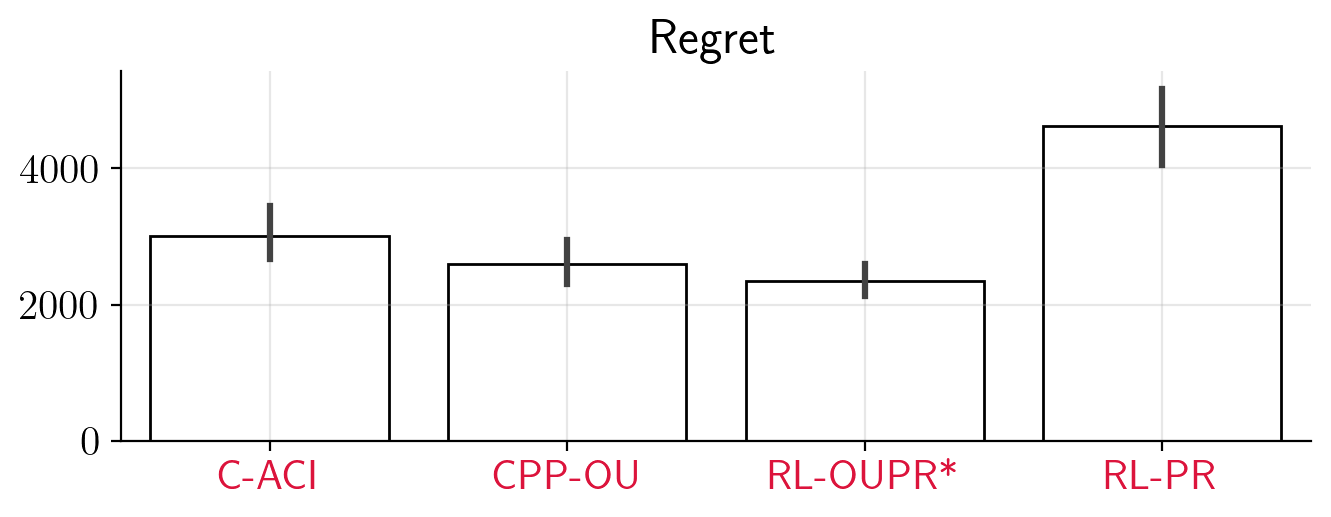

In [33]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 0.5))

sns.barplot(
    x="variable",
    y="value",
    data=results_last.melt(),
    color="white",
    edgecolor="black",
    errorbar=("pi", 95)
)

for ticklabel in plt.gca().get_xticklabels():
    label = ticklabel.get_text()
    tickcolor = "teal" if "SPR" in label else "crimson"
    ticklabel.set_color(tickcolor)

plt.title("Regret")
plt.xlabel("")
plt.ylabel("")
plt.grid(alpha=0.3)

# plt.savefig("./figures/regret-bandit-final.png", dpi=300, bbox_inches="tight")